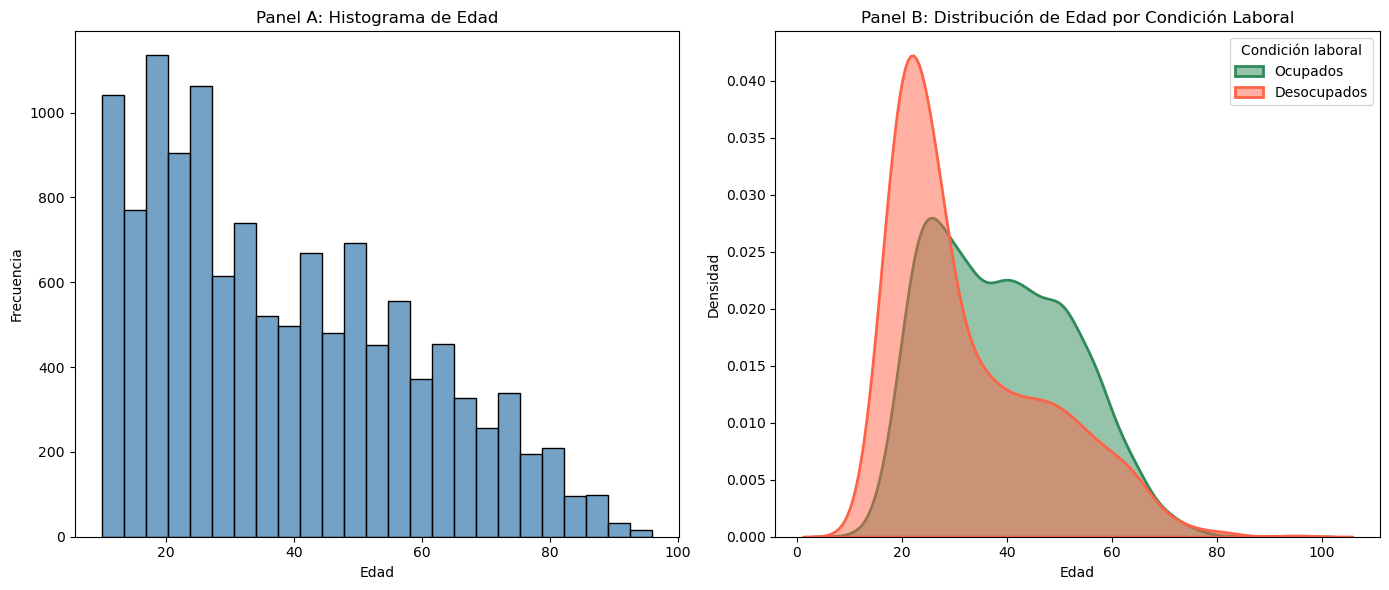

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar archivo
df = pd.read_excel("resultado_pampeana09.xlsx")

# Filtrar por años 2004 y 2024
df = df[df["ano4"].isin([2004, 2024])].copy()

# Normalizar sexo
def normalizar_ch04(valor, año):
    if año == 2004:
        if str(valor).strip().lower() in ["varón", "hombre", "m"]:
            return "Hombre"
        elif str(valor).strip().lower() in ["mujer", "f"]:
            return "Mujer"
    elif año == 2024:
        if valor == 1:
            return "Hombre"
        elif valor == 2:
            return "Mujer"
        elif valor == 3:
            return "Otro"
    return None

df["sexo"] = df.apply(lambda row: normalizar_ch04(row["CH04"], row["ano4"]), axis=1)

# Edad válida
df["edad"] = pd.to_numeric(df["CH06"], errors="coerce")
df = df[df["edad"].notna() & (df["edad"] >= 10)]

# Edad al cuadrado
df["edad2"] = df["edad"] ** 2

# Unificar columna ESTADO según año
def normalizar_estado(row):
    if row["ano4"] == 2004:
        val = str(row["ESTADO"]).strip().lower()
        if val == "ocupado":
            return "Ocupado"
        elif val == "desocupado":
            return "Desocupado"
        elif val == "inactivo":
            return "Inactivo"
    elif row["ano4"] == 2024:
        val = row["ESTADO"]
        if val == 1:
            return "Ocupado"
        elif val == 2:
            return "Desocupado"
        elif val == 3:
            return "Inactivo"
    return None

df["cond_laboral"] = df.apply(normalizar_estado, axis=1)

# Filtrar solo ocupados y desocupados
df_od = df[df["cond_laboral"].isin(["Ocupado", "Desocupado"])]

# Gráficos
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Histograma
sns.histplot(df["edad"], bins=25, color="steelblue", ax=axes[0])
axes[0].set_title("Panel A: Histograma de Edad")
axes[0].set_xlabel("Edad")
axes[0].set_ylabel("Frecuencia")

# Panel B: KDE
sns.kdeplot(
    data=df_od[df_od["cond_laboral"] == "Ocupado"],
    x="edad",
    label="Ocupados",
    fill=True,
    color="seagreen",
    alpha=0.5,
    linewidth=2,
    warn_singular=False,
    ax=axes[1]
)
sns.kdeplot(
    data=df_od[df_od["cond_laboral"] == "Desocupado"],
    x="edad",
    label="Desocupados",
    fill=True,
    color="tomato",
    alpha=0.5,
    linewidth=2,
    warn_singular=False,
    ax=axes[1]
)
axes[1].set_title("Panel B: Distribución de Edad por Condición Laboral")
axes[1].set_xlabel("Edad")
axes[1].set_ylabel("Densidad")
axes[1].legend(title="Condición laboral")

plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import numpy as np

# Cargar archivo
df = pd.read_excel("resultado_pampeana091.xlsx")
df = df[df["ano4"].isin([2004, 2024])].copy()

# Limpiar campos texto
for col in ["CH12", "CH13", "CH14"]:
    df[col] = df[col].astype(str).str.strip().str.lower().replace({"nan": np.nan, "": np.nan})

# Función para calcular educ
def calcular_educ(row):
    ch12 = row["CH12"]
    ch13 = row["CH13"]
    ch14 = row["CH14"]
    año = row["ano4"]

    if pd.isna(ch12):
        return np.nan

    # BASE por nivel educativo
    base = 0

    if año == 2024:
        try:
            ch12 = int(ch12)
        except:
            return np.nan

        if ch12 in [1]: base = 0  # jardín
        elif ch12 in [2, 3]: base = 0  # primario / EGB
        elif ch12 in [4, 5]: base = 7
        elif ch12 == 6: base = 13
        elif ch12 == 7: base = 13
        elif ch12 == 8: base = 17
        else: return np.nan

    elif año == 2004:
        if "jard" in ch12 or "preescolar" in ch12:
            base = 0
        elif "primario" in ch12:
            base = 0
        elif "egb" in ch12:
            base = 0
        elif "secundario" in ch12 or "polimodal" in ch12:
            base = 7
        elif "terciario" in ch12:
            base = 13
        elif "universitario" in ch12:
            base = 13
        elif "posgrado" in ch12:
            base = 17
        else:
            return np.nan

    # Año aprobado
    try:
        aprobado = int(ch14)
        if aprobado in range(1, 10):
            adicional = aprobado
        else:
            adicional = 0
    except:
        adicional = 0

    # Finalizó?
    finalizo = str(ch13).lower()
    extra = 1 if finalizo in ["sí", "si", "s", "1"] else 0

    return base + adicional + extra

# Calcular
df["educ"] = df.apply(calcular_educ, axis=1)

# Estadísticas descriptivas
educ_stats = df["educ"].dropna().describe(percentiles=[0.5])[["mean", "std", "min", "50%", "max"]]
educ_stats.rename(index={"50%": "p50"}, inplace=True)
print(educ_stats)


mean     6.551599
std      5.281008
min      0.000000
p50      7.000000
max     20.000000
Name: educ, dtype: float64


###Media (mean): El valor promedio de años de educación es de 6.55 años. Esto significa que, en promedio, las personas de la muestra han completado alrededor de 6 años de escolaridad formal, lo cual es una mezcla de niveles educativos, con muchos individuos que quizás no han terminado la secundaria o que se encuentran en la transición entre niveles educativos.

Desviación estándar (std): La desviación estándar es 5.28, lo que indica que hay una considerable dispersión entre los años de educación de las personas en la muestra. Esto sugiere que hay tanto individuos con baja educación (menos de 5 años) como aquellos con una educación más avanzada (más de 10 o 15 años). Es decir, la muestra tiene una gran variabilidad en los niveles educativos.

Mínimo (min): El valor mínimo es 0, lo que indica que hay individuos que no han cursado ningún nivel educativo. Esto podría ser el caso de personas muy jóvenes o de aquellos que, por diversas razones, no han asistido a la escuela.

Mediana (p50): El valor de la mediana es 7 años, lo que significa que la mitad de los individuos de la muestra tienen 7 años o menos de educación formal. Este es un indicador clave de la distribución, mostrando que, en general, muchos de los encuestados no han completado la educación secundaria.

Máximo (max): El valor máximo es 20 años, lo que representa el caso de una persona que ha completado, por ejemplo, una educación universitaria completa, incluyendo un posgrado o especialización. Esto también muestra que la muestra tiene personas con niveles educativos muy altos.

Resumen:
La distribución de los años de educación es bastante dispersa. Si bien la media está en 6.55 años, la mediana (7 años) nos indica que hay una gran cantidad de personas con niveles educativos cercanos a la secundaria, pero también existen individuos con niveles educativos significativamente más altos, lo que refleja la diversidad en el acceso a la educación en tu muestra. La desviación estándar también muestra que esta variabilidad es notable.

Conclusión:
Este análisis refleja que, a pesar de que la mayoría de las personas en la muestra tienen alrededor de 7 años de escolaridad (es decir, secundaria incompleta o completa), existe una heterogeneidad significativa, con personas que tienen tanto una educación baja como avanzada. Esto podría deberse a diferencias en el acceso a la educación, edad de los encuestados, y las posibilidades de continuar la educación más allá del nivel básico.

 

In [4]:
#PUNTO 3

import pandas as pd

# Cargar el archivo
df = pd.read_excel("resultado_pampeana0911.xlsx")

# Filtrar por años 2004 y 2024
df = df[df["ano4"].isin([2004, 2024])].copy()

# Asegurar que las columnas sean numéricas
df["PP3E_TOT"] = pd.to_numeric(df["PP3E_TOT"], errors="coerce")
df["PP3F_TOT"] = pd.to_numeric(df["PP3F_TOT"], errors="coerce")

# Crear variable horastrab (ocupación principal + secundaria)
df["horastrab"] = df["PP3E_TOT"] + df["PP3F_TOT"]

# Filtrar: solo valores entre 1 y 100 horas semanales
df_filtrado = df[(df["horastrab"] > 0) & (df["horastrab"] <= 100)]

# Estadística descriptiva
stats = df_filtrado["horastrab"].describe(percentiles=[0.5])[["mean", "std", "min", "50%", "max"]]
stats.rename(index={"50%": "p50"}, inplace=True)

# Mostrar resultados
print(stats)

mean     40.619669
std      19.458817
min       1.000000
p50      40.000000
max     100.000000
Name: horastrab, dtype: float64


### Luego de limpiar los datos y quedarnos únicamente con las observaciones que reportaron una cantidad lógica de horas trabajadas (entre 1 y 100 horas semanales), se obtuvieron estadísticas descriptivas más representativas de la población ocupada. El promedio de horas trabajadas por semana se ubicó en aproximadamente 40,6 horas, con una mediana de 40 horas, lo cual indica que la mayoría de los trabajadores desempeñan jornadas laborales cercanas al estándar de tiempo completo.

La desviación estándar, de 19,5 horas, sugiere una considerable variabilidad en las cargas horarias, reflejando la coexistencia de distintas modalidades de empleo, como trabajo part-time, empleo informal o pluriempleo. El mínimo registrado fue de 1 hora semanal, lo cual puede responder a empleos muy esporádicos, mientras que el máximo de 100 horas podría estar vinculado a personas con múltiples ocupaciones o a situaciones de subregistro en los cuestionarios.

En resumen, estos valores ofrecen una mirada más precisa del régimen laboral semanal entre los ocupados, eliminando el sesgo que podría introducirse por errores de carga o la inclusión de personas inactivas o desocupadas. Esto permite realizar inferencias más ajustadas respecto al esfuerzo laboral y sus posibles implicancias en términos de bienestar y calidad de vida.

In [ ]:
PUNTO 3 

In [ ]:
import pandas as pd
#FILTRAMOS Y HOMOGENEIZAMOS LOS DATOS 
# Cargar los datos
df_2024 = pd.read_excel('usu_individual_T124.xlsx')
df_2004 = pd.read_excel('usu_individual_T104.xlsx')

# Homogeneizar nombres de columnas en df_2004
df_2004 = df_2004.rename(columns={
    'region': 'REGION',
    'estado': 'ESTADO',
    'ch04': 'CH04',
    'ch12': 'CH12'
})

# Homogeneizar REGION (Pampeana = 43 en df_2004)
df_2004['REGION'] = df_2004['REGION'].replace({'Pampeana': 43})

# Mapeos (solo para df_2024)
estado_map = {
    0: 'No respondió',
    1: 'Ocupado',
    2: 'Desocupado',
    3: 'Inactivo',
    4: 'Menor de 10 años'
}

sexo_map = {
    1: 'Varón',
    2: 'Mujer'
}

educacion_map = {
    1: 'Sin instrucción',
    2: 'Primaria incompleta',
    3: 'Primaria completa',
    4: 'Secundaria incompleta',
    5: 'Secundaria completa',
    6: 'Superior universitaria incompleta',
    7: 'Superior universitaria completa',
    9: 'Ns/Nr'
}

# Asegurar que las columnas clave sean tipo 'object' en ambos DataFrames
columnas_clave = ['ESTADO', 'CH04', 'CH12']

# Para df_2024 
df_2024[columnas_clave] = df_2024[columnas_clave].astype('object')
df_2024['ESTADO'] = df_2024['ESTADO'].map(estado_map)
df_2024['CH04'] = df_2024['CH04'].map(sexo_map)
df_2024['CH12'] = df_2024['CH12'].map(educacion_map)

# Para df_2004 
df_2004[columnas_clave] = df_2004[columnas_clave].astype('object')

# Filtrar por región (Pampeana = 43)
df_2024_region = df_2024[df_2024['REGION'] == 43].copy()
df_2004_region = df_2004[df_2004['REGION'] == 43].copy()

# Filtrar respondieron/no respondieron (solo en df_2024)
respondieron_2024 = df_2024_region[df_2024_region['ESTADO'] != 'No respondió'].copy()
norespondieron_2024 = df_2024_region[df_2024_region['ESTADO'] == 'No respondió'].copy()

# Guardar en un solo archivo Excel
with pd.ExcelWriter('datos_homogeneizados_final.xlsx') as writer:
    respondieron_2024.to_excel(writer, sheet_name='Respondieron_2024', index=False)
    norespondieron_2024.to_excel(writer, sheet_name='NoRespondieron_2024', index=False)
    df_2004_region.to_excel(writer, sheet_name='Datos_2004_original', index=False)  

print("Proceso completado. Datos 2024 mapeados y datos 2004 conservados en formato original.")

In [ ]:
import pandas as pd

#AGREGAMOS COLUMNA SALARIO SEMANAL 
def procesar_salario():
    # Cargar el archivo Excel
    archivo = 'datos_homogeneizados_final.xlsx'
    
    # Leer las hojas necesarias
    try:
        respondieron_2024 = pd.read_excel(archivo, sheet_name='Respondieron_2024')
        no_respondieron_2024 = pd.read_excel(archivo, sheet_name='NoRespondieron_2024')
        datos_2004 = pd.read_excel(archivo, sheet_name='Datos_2004_original')
    except Exception as e:
        print(f"Error al leer el archivo: {e}")
        return None

    # Función para procesar cada DataFrame
    def procesar_df(df, es_2004=False):
        # Estandarizar nombres de columnas
        df = df.rename(columns={
            'ANO4' if 'ANO4' in df.columns else 'ano4': 'anio',
            'P21' if 'P21' in df.columns else 'p21': 'p21'
        })
        
        # Filtrar valores positivos
        df['p21'] = pd.to_numeric(df['p21'], errors='coerce')
        df = df[df['p21'] >= 0].copy()
        
        # Calcular salario semanal
        if es_2004:
            df['salario_semanal'] = (df['p21'] * 1030.91) / 40
        else:
            df['salario_semanal'] = df['p21'] / 40
        
        return df

    # Procesar cada conjunto de datos
    respondieron_2024 = procesar_df(respondieron_2024)
    no_respondieron_2024 = procesar_df(no_respondieron_2024)
    datos_2004 = procesar_df(datos_2004, es_2004=True)

    # Combinar todos los datos 
    datos_completos = pd.concat([
        respondieron_2024,
        no_respondieron_2024,
        datos_2004
    ], ignore_index=True)

    # Guardar resultados
    with pd.ExcelWriter('resultados_procesados.xlsx') as writer:
        respondieron_2024.to_excel(writer, sheet_name='Respondieron_2024_proc', index=False)
        no_respondieron_2024.to_excel(writer, sheet_name='NoRespondieron_2024_proc', index=False)
        datos_2004.to_excel(writer, sheet_name='2004_procesado', index=False)
        datos_completos.to_excel(writer, sheet_name='Datos_Completos', index=False)

    print("Procesamiento completado. Resultados guardados en 'resultados_procesados.xlsx'")
    return datos_completos

# Ejecutar la función
datos_finales = procesar_salario()

C:\Users\54113\AppData\Local\Temp\ipykernel_784\2161551154.py:54: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.kdeplot(data=datos_filtrados, x='salario_semanal', hue='Estado_agrupado',


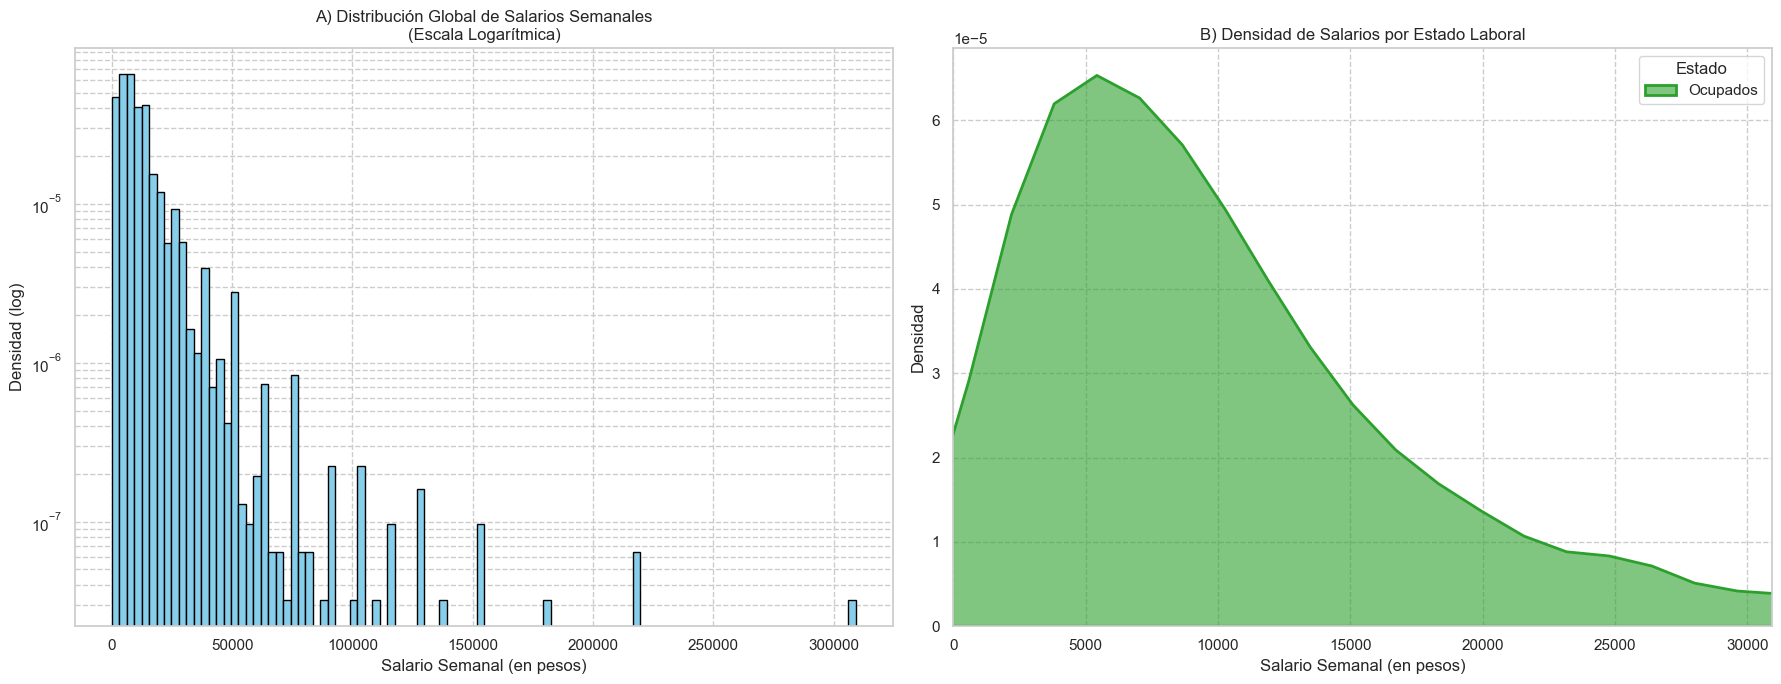

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración estética
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

# Cargar las hojas procesadas
respondieron = pd.read_excel('resultados_salario_semanal.xlsx', sheet_name='Respondieron_2024_proc')
no_respondieron = pd.read_excel('resultados_salario_semanal.xlsx', sheet_name='NoRespondieron_2024_proc')
datos_2004 = pd.read_excel('resultados_salario_semanal.xlsx', sheet_name='2004_procesado')

# Combinar los datos manteniendo las columnas relevantes
columnas_necesarias = ['anio', 'salario_semanal', 'ESTADO']
datos_salarios = pd.concat([
    respondieron[columnas_necesarias],
    no_respondieron[columnas_necesarias],
    datos_2004[columnas_necesarias]
], ignore_index=True)

# Filtrar valores positivos y válidos
datos_salarios = datos_salarios[(datos_salarios['salario_semanal'] > 0) & 
                               (datos_salarios['ESTADO'].notna())]

# Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

## Panel A: Histograma de salario_semanal
ax1.hist(datos_salarios['salario_semanal'], bins=100, color='skyblue', 
         edgecolor='black', log=True, density=True)
ax1.set_title('A) Distribución Global de Salarios Semanales\n(Escala Logarítmica)')
ax1.set_xlabel('Salario Semanal (en pesos)')
ax1.set_ylabel('Densidad (log)')
ax1.grid(True, which="both", ls="--")

## Panel B: Distribuciones Kernel por Estado (Ocupado/Desocupado)
# Primero categorizamos los estados 
ocupacion = {
    'Ocupado': ['Ocupado', 'Empleado', 'Trabajador'],
    'Desocupado': ['Desocupado', 'Desempleado', 'Inactivo']
}

# Mapear las categorías
datos_salarios['Estado_agrupado'] = datos_salarios['ESTADO'].map(
    lambda x: next((k for k, v in ocupacion.items() if x in v), 'Otro')
)

# Filtrar solo Ocupados y Desocupados
datos_filtrados = datos_salarios[datos_salarios['Estado_agrupado'].isin(['Ocupado', 'Desocupado'])]

sns.kdeplot(data=datos_filtrados, x='salario_semanal', hue='Estado_agrupado',
            ax=ax2, fill=True, common_norm=False, 
            palette=['#2ca02c', '#d62728'],  # Verde para ocupados, rojo para desocupados
            alpha=0.6, linewidth=2)
ax2.set_title('B) Densidad de Salarios por Estado Laboral')
ax2.set_xlabel('Salario Semanal (en pesos)')
ax2.set_ylabel('Densidad')
ax2.set_xlim(0, datos_filtrados['salario_semanal'].quantile(0.95))  # Excluir outliers extremos
ax2.legend(title='Estado', labels=['Ocupados', 'Desocupados'])
ax2.grid(True, ls="--")

plt.tight_layout()
plt.savefig('distribucion_salarios_por_estado.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
COMENTARIO PUNTO 3: 

Panel A: La distribución global de salarios muestra una marcada asimetría positiva, con una alta concentración de ingresos bajos y una larga
cola hacia valores superiores. El uso de escala logarítmica permite visualizar mejor la concentración en el rango inferior.
Panel B- Densidad por Estado Laboral (Ocupados):
Distribución unimodal: Los ocupados muestran un pico único alrededor de 5000-10000 pesos semanales.
Simetria positiva: La curva se inclina hacia la derecha, con una cola que llega hasta 30000 pesos.
El gráfico solo muestra datos para ocupados .

In [ ]:
PUNTO 5

In [ ]:
import pandas as pd

# Cargar los datos directamente desde las hojas
def cargar_datos_completos():
    hojas = {
        '2004': '2004_procesado',
        '2024_respondieron': 'Respondieron_2024_proc', 
        '2024_norespondieron': 'NoRespondieron_2024_proc'
    }
    
    datos_completos = []
    for nombre, hoja in hojas.items():
        df = pd.read_excel('resultados_salario_semanal.xlsx', sheet_name=hoja)
        df['periodo'] = nombre.split('_')[0] 
        datos_completos.append(df)
    
    return pd.concat(datos_completos, ignore_index=True)

# Filtrar específicamente para región 43
datos = cargar_datos_completos()
datos_r43 = datos[datos['REGION'] == 43]  

# Crear tabla resumen 
tabla_resumen = pd.DataFrame({
    '2004': [
        len(datos_r43[datos_r43['periodo'] == '2004']),
        datos_r43[datos_r43['periodo'] == '2004']['ESTADO'].isna().sum(),
        (datos_r43[datos_r43['periodo'] == '2004']['ESTADO'] == 'Ocupado').sum(),
        (datos_r43[datos_r43['periodo'] == '2004']['ESTADO'] == 'Desocupado').sum(),
        sum(datos_r43[datos_r43['periodo'] == '2004'].notna().all(axis=1))
    ],
    '2024': [
        len(datos_r43[datos_r43['periodo'] == '2024']),
        datos_r43[datos_r43['periodo'] == '2024']['ESTADO'].isna().sum(),
        (datos_r43[datos_r43['periodo'] == '2024']['ESTADO'] == 'Ocupado').sum(),
        (datos_r43[datos_r43['periodo'] == '2024']['ESTADO'] == 'Desocupado').sum(),
        sum(datos_r43[datos_r43['periodo'] == '2024'].notna().all(axis=1))
    ],
    'Total': [
        len(datos_r43),
        datos_r43['ESTADO'].isna().sum(),
        (datos_r43['ESTADO'] == 'Ocupado').sum(),
        (datos_r43['ESTADO'] == 'Desocupado').sum(),
        sum(datos_r43.notna().all(axis=1))
    ]
}, index=[
    'Cantidad observaciones',
    'Cantidad de observaciones con Nas en la variable "Estado"',
    'Cantidad de Ocupados',
    'Cantidad de Desocupados',
    'Cantidad de variables limpias y homogeneizadas'
])

# Mostrar resultados
print("Tabla 1. Resumen de la base final para la región 43")
print(tabla_resumen.transpose())  

# Guardar resultados
tabla_resumen.to_excel('tabla_resumen_region43.xlsx')

In [ ]:
PARTE II 

In [ ]:
PUNTO 5A

Cargando datos...

Datos cargados correctamente. Total de registros: 27823
Distribución por año:
fuente
2004    14821
2024    13002
Name: count, dtype: int64

Procesando niveles educativos...

Valores educativos no reconocidos: ['sin instrucción' 'nan' 'ns/nr' 'secundario' 'polimodal' 'egb' 'primario'
 'terciario' '0' 'universitario' 'jard�n/preescolar'
 'educaci�n especial (discapacitado)' 'posgrado universitario' 'ns./nr.']

Datos válidos para clustering: 11953 registros

Distribución por nivel educativo normalizado:
nivel_educ_normalizado
Secundario Incompleto         4486
Primario Incompleto           3040
Terciario/Univ. Completo      1921
Terciario/Univ. Incompleto    1203
Primario Completo              732
Secundario Completo            571
Name: count, dtype: int64

Ejecutando análisis de clustering...


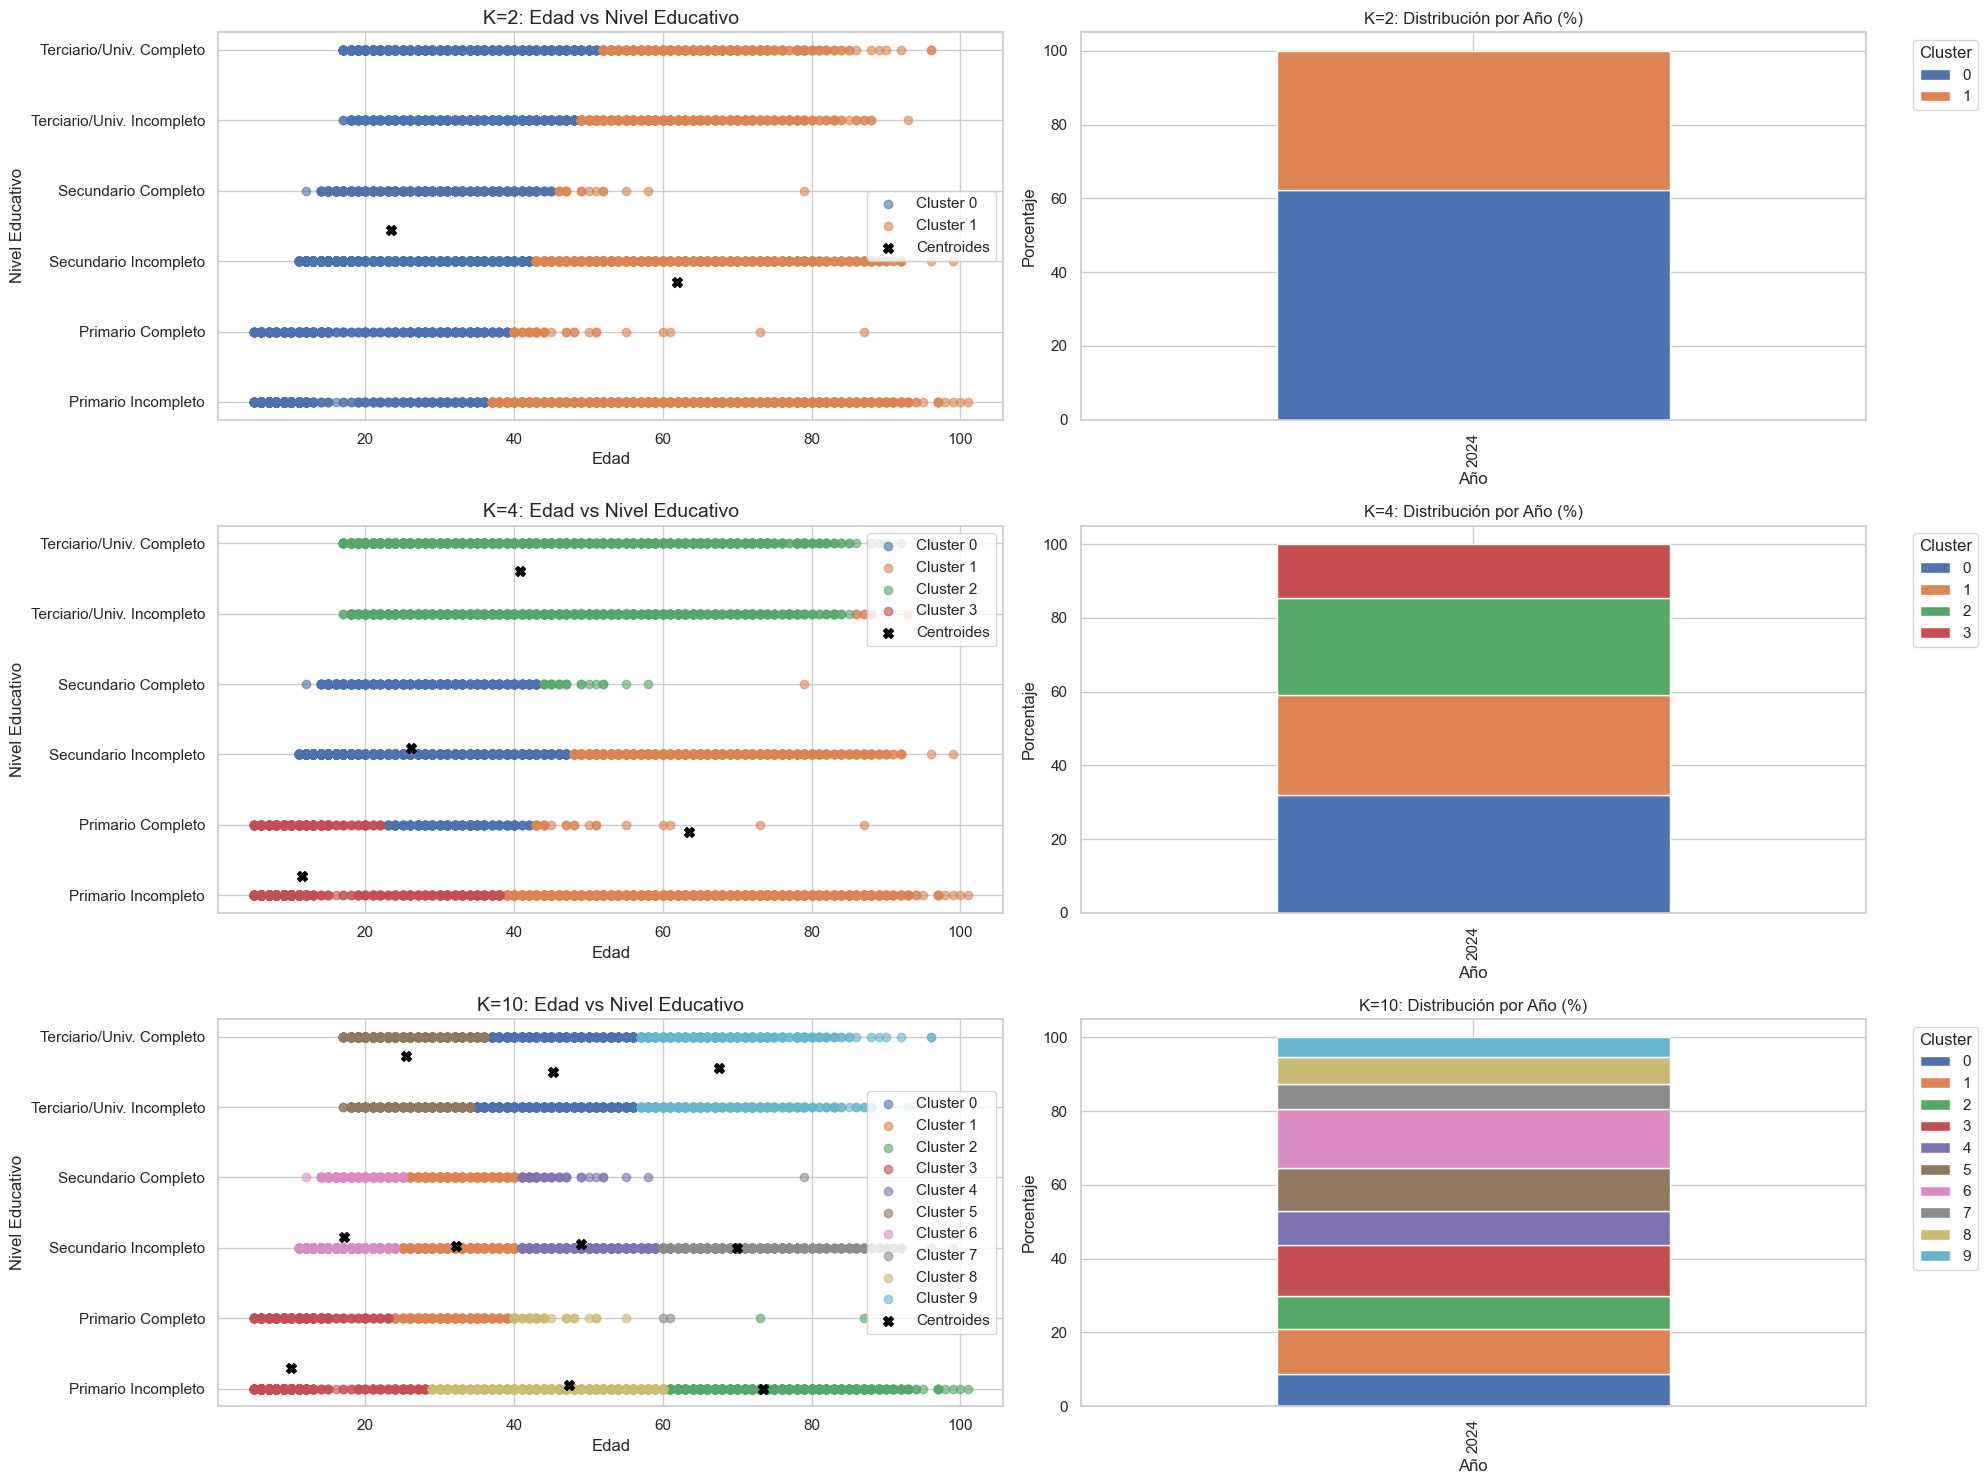


Proceso completado exitosamente!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Configuración visual
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True

# Archivo y configuración de hojas
FILE_NAME = "archivo_actualizado.xlsx"
SHEETS = {
    'Respondieron_2024_proc': {'col_edad': 'edad', 'col_nivel_ed': 'nivel_educ'},
    'NoRespondieron_2024_proc': {'col_edad': 'edad', 'col_nivel_ed': 'nivel_educ'},
    '2004_procesado': {'col_edad': 'edad', 'col_nivel_ed': 'CH12'}
}

# Mapeo y orden de niveles educativos 
orden_nivel = [
    'Primario Incompleto',
    'Primario Completo',
    'Secundario Incompleto',
    'Secundario Completo',
    'Terciario/Univ. Incompleto',
    'Terciario/Univ. Completo'
]

# Mapeo flexible para normalizar los valores educativos
mapeo_flexible = {
    'primaria incompleta': 'Primario Incompleto',
    'primario incompleto': 'Primario Incompleto',
    'primaria completa': 'Primario Completo',
    'primario completo': 'Primario Completo',
    'secundaria incompleta': 'Secundario Incompleto',
    'secundario incompleto': 'Secundario Incompleto',
    'secundaria completa': 'Secundario Completo',
    'secundario completo': 'Secundario Completo',
    'superior universitaria incompleta': 'Terciario/Univ. Incompleto',
    'terciario incompleto': 'Terciario/Univ. Incompleto',
    'universitaria incompleta': 'Terciario/Univ. Incompleto',
    'superior universitaria completa': 'Terciario/Univ. Completo',
    'terciario completo': 'Terciario/Univ. Completo',
    'universitaria completa': 'Terciario/Univ. Completo'
}

# Mapeo inverso para valores numéricos
mapa_nivel_ed_inv = {v: i for i, v in enumerate(orden_nivel)}
mapa_nivel_ed_inv['Desconocido'] = -1

def cargar_datos():
    """Carga y combina datos de todas las hojas especificadas"""
    datos_combinados = []
    
    for hoja, columnas in SHEETS.items():
        try:
            # Leer hoja Excel
            df = pd.read_excel(FILE_NAME, sheet_name=hoja)
            if df.empty:
                print(f"Advertencia: Hoja {hoja} está vacía")
                continue
                
            # Verificar columnas 
            for col in ['col_edad', 'col_nivel_ed']:
                if columnas[col] not in df.columns:
                    print(f"Advertencia: Columna {columnas[col]} no encontrada en hoja {hoja}")
                    continue
            
            # Procesar datos
            df_procesado = pd.DataFrame()
            df_procesado['edad'] = pd.to_numeric(df[columnas['col_edad']], errors='coerce')
            df_procesado['nivel_educ'] = df[columnas['col_nivel_ed']].astype(str).str.strip().str.lower()
            df_procesado['fuente'] = '2024' if '2024' in hoja else '2004'
            
            datos_combinados.append(df_procesado)
            
        except Exception as e:
            print(f"Error procesando hoja {hoja}: {str(e)}")
            continue
            
    if not datos_combinados:
        raise ValueError("Ninguna hoja contenía datos válidos")
        
    return pd.concat(datos_combinados, ignore_index=True)

def procesar_nivel_educativo(df):
    """Normaliza y mapea los niveles educativos"""
    # Normalizar valores
    df['nivel_educ_normalizado'] = df['nivel_educ'].map(mapeo_flexible).fillna('Desconocido')
    
    # Identificar valores no mapeados
    no_mapeados = df[df['nivel_educ_normalizado'] == 'Desconocido']['nivel_educ'].unique()
    if len(no_mapeados) > 0:
        print("\nValores educativos no reconocidos:", no_mapeados)
    
    # Asignar valores numéricos
    df['nivel_educ_num'] = df['nivel_educ_normalizado'].map(mapa_nivel_ed_inv)
    
    return df

def ejecutar_clustering(datos_validos):
    """Ejecuta el análisis de clustering y genera gráficos"""
    # Escalado de características
    X = datos_validos[['edad', 'nivel_educ_num']].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Configuración de clustering
    k_values = [2, 4, 10]
    n_init = 20
    random_state = 42
    
    # Preparar gráficos
    fig, axes = plt.subplots(len(k_values), 2, figsize=(20, 15))
    
    for i, k in enumerate(k_values):
        # K-Means clustering
        kmeans = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
        clusters = kmeans.fit_predict(X_scaled)
        datos_validos[f'cluster_k{k}'] = clusters
        
        # Gráfico de dispersión
        ax = axes[i, 0]
        for cluster in range(k):
            cluster_data = datos_validos[datos_validos[f'cluster_k{k}'] == cluster]
            ax.scatter(cluster_data['edad'], cluster_data['nivel_educ_num'],
                      label=f'Cluster {cluster}', alpha=0.6)
        
        # Centroides
        centroides = scaler.inverse_transform(kmeans.cluster_centers_)
        ax.scatter(centroides[:, 0], centroides[:, 1], s=50, c='black', marker='X', label='Centroides')
        ax.set_yticks(range(len(orden_nivel)))
        ax.set_yticklabels(orden_nivel)
        ax.set_title(f'K={k}: Edad vs Nivel Educativo', fontsize=14)
        ax.set_xlabel('Edad')
        ax.set_ylabel('Nivel Educativo')
        ax.legend()
        
        # Gráfico de distribución por año
        ax = axes[i, 1]
        dist = datos_validos.groupby(['fuente', f'cluster_k{k}']).size().unstack()
        dist_percent = dist.div(dist.sum(axis=1), axis=0) * 100
        dist_percent.plot(kind='bar', stacked=True, ax=ax)
        ax.set_title(f'K={k}: Distribución por Año (%)')
        ax.set_ylabel('Porcentaje')
        ax.set_xlabel('Año')
        ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

def main():
    try:
        # 1. Cargar datos
        print("Cargando datos...")
        datos = cargar_datos()
        print(f"\nDatos cargados correctamente. Total de registros: {len(datos)}")
        print("Distribución por año:")
        print(datos['fuente'].value_counts())
        
        # 2. Procesar niveles educativos
        print("\nProcesando niveles educativos...")
        datos = procesar_nivel_educativo(datos)
        
        # 3. Filtrar datos válidos
        condicion = (datos['edad'] > 0) & (datos['nivel_educ_num'] >= 0)
        datos_validos = datos[condicion].copy()
        
        if len(datos_validos) == 0:
            raise ValueError("No hay datos válidos después del filtrado")
            
        print(f"\nDatos válidos para clustering: {len(datos_validos)} registros")
        print("\nDistribución por nivel educativo normalizado:")
        print(datos_validos['nivel_educ_normalizado'].value_counts())
        
        # 4. Ejecutar clustering
        print("\nEjecutando análisis de clustering...")
        ejecutar_clustering(datos_validos)
        
        print("\nProceso completado exitosamente!")
        
    except Exception as e:
        print(f"\nERROR: {str(e)}")
        print("\nPosibles soluciones:")
        print("- Verifica que el archivo Excel existe y tiene las hojas correctas")
        print("- Revisa que los nombres de las columnas coincidan")
        print("- Comprueba los valores educativos no mapeados")
        print("- Asegúrate que hay registros con edad > 0")

if __name__ == "__main__":
    main() 

In [ ]:
COMENTARIO 5A 
Los gráficos muestran que los grupos formados por edad y nivel educativo son consistentes entre 2004 y 2024.
A mayor número de clusters, se observa una mayor diferenciación entre edades más jóvenes con menor educación y adultos con niveles educativos más altos.
El valor de K=10 permite visualizar con mayor detalle la heterogeneidad de la población:
revela subgrupos más específicos en términos de edad y nivel educativo.
A diferencia de K=2 o K=4, donde los clusters son más generales, K=10 muestra matices como jóvenes con alto nivel educativo,
adultos mayores con bajo nivel, etc.
Esto permite una interpretación más fina de los patrones sociales y educativos.

In [ ]:
5A BIS (CON OTRAS VARIABLES)

Cargando y preparando datos...
Datos válidos cargados: 10066 registros


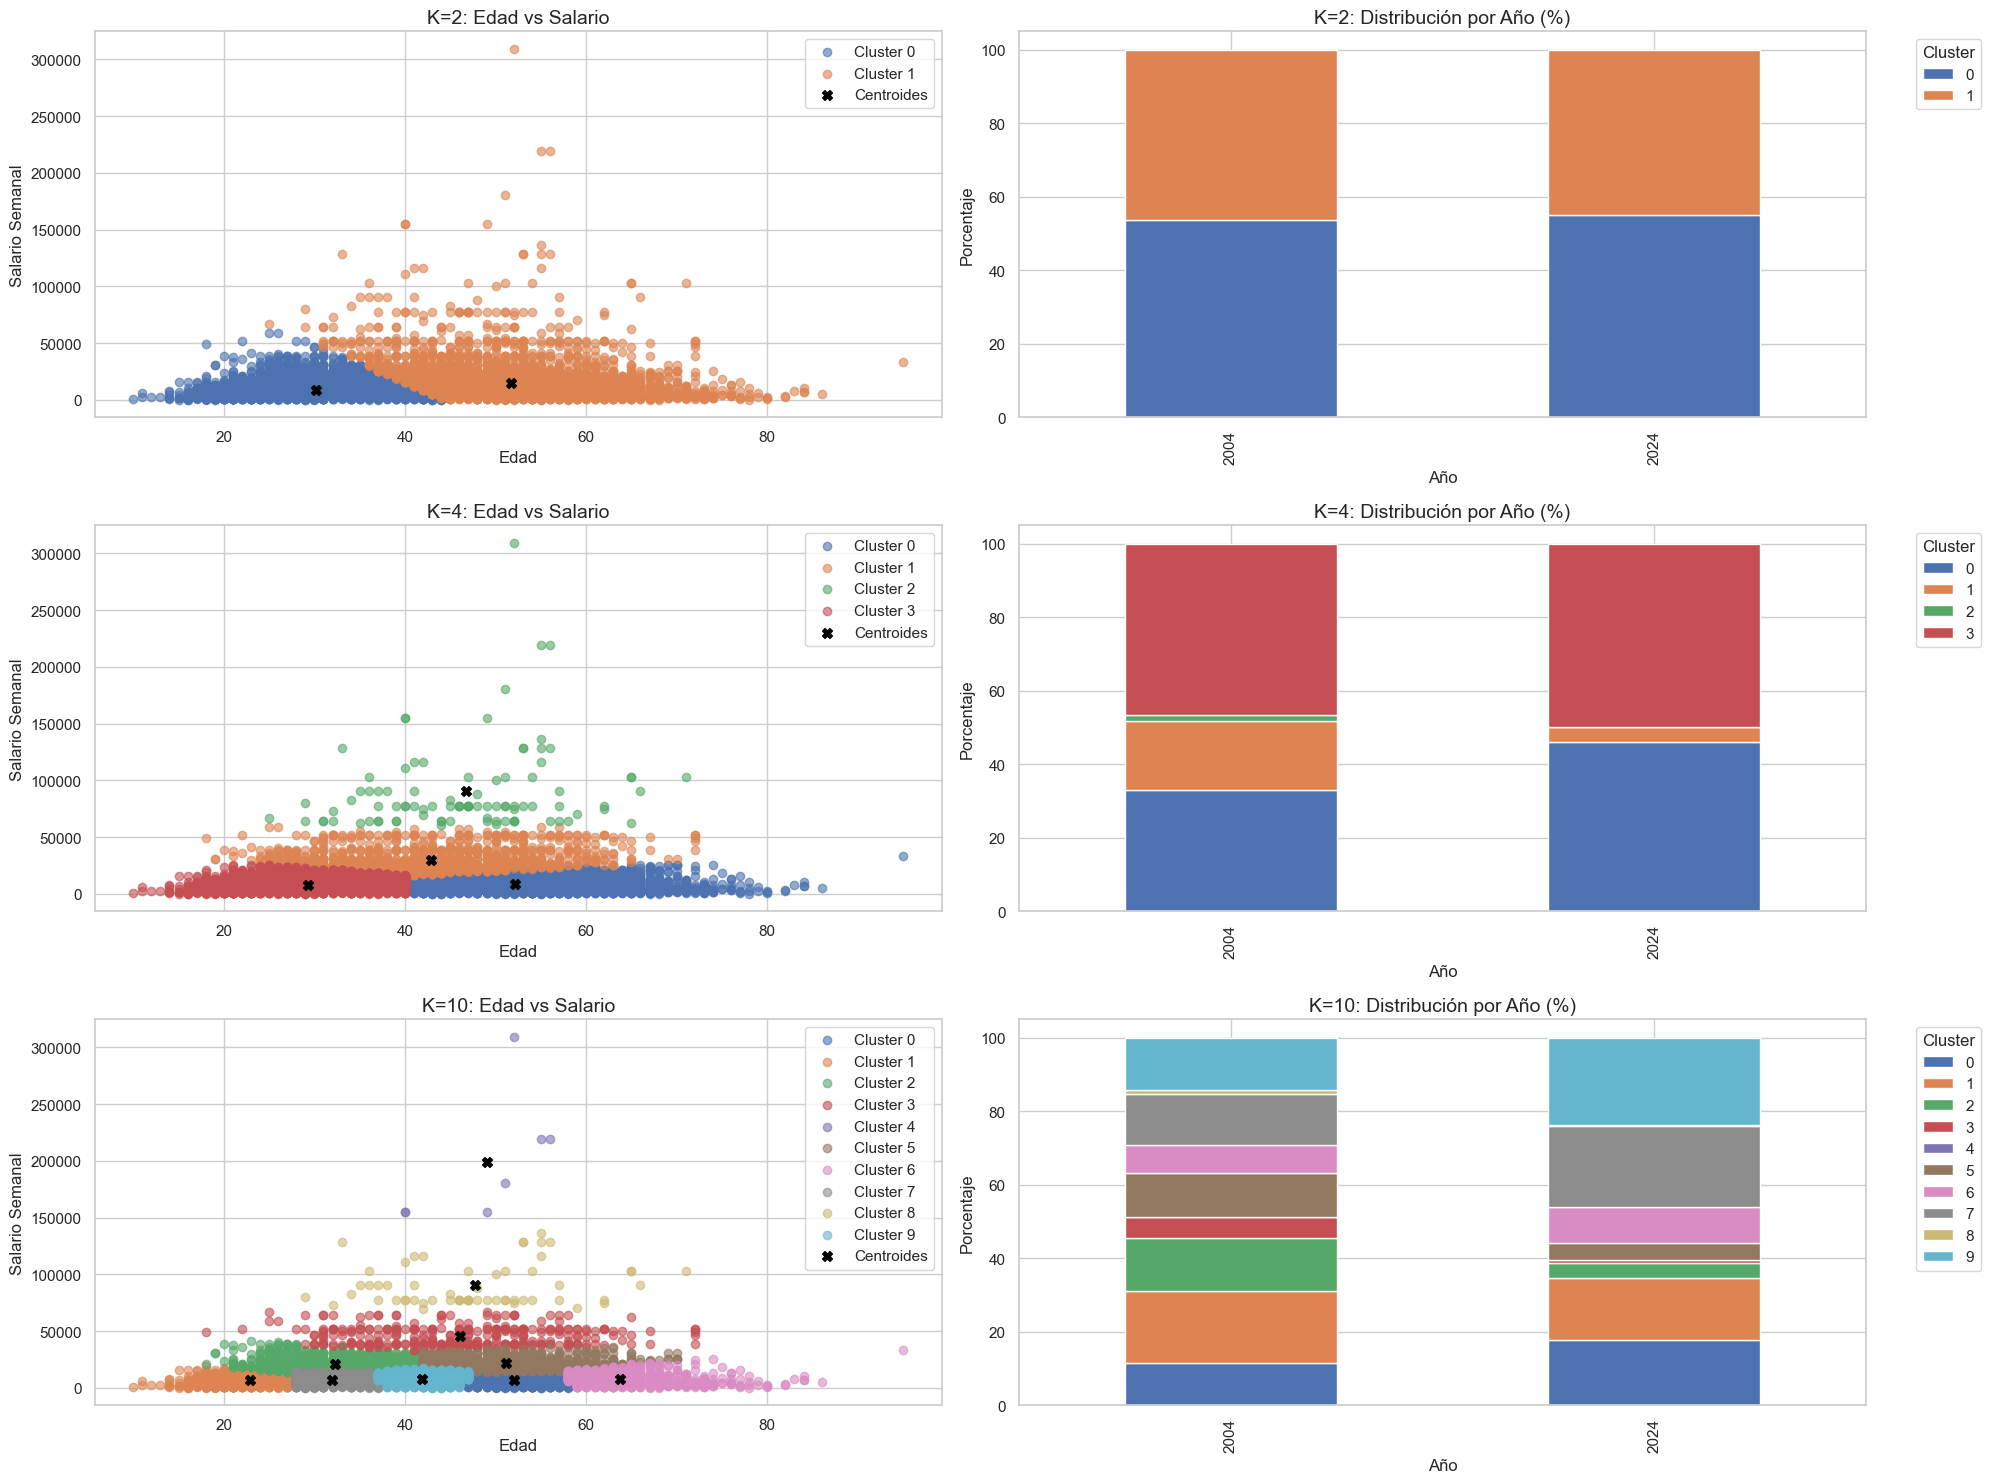

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Configuración de visualización 
plt.rcParams['figure.figsize'] = [20, 15]  
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True  

# Configuración de archivo
FILE_NAME = "resultados_salario_semanal.xlsx"
SHEETS = {
    'Respondieron_2024_proc': {'col_edad': 'CH06', 'col_salario': 'salario_semanal'},
    'NoRespondieron_2024_proc': {'col_edad': 'CH06', 'col_salario': 'salario_semanal'},
    '2004_procesado': {'col_edad': 'ch06', 'col_salario': 'salario_semanal'}
}

def cargar_datos():
    """Carga y prepara los datos con nombres simplificados de año"""
    datos_combinados = []
    
    for hoja, columnas in SHEETS.items():
        try:
            df = pd.read_excel(FILE_NAME, sheet_name=hoja)
            
            # Convertir a numérico
            df['edad'] = pd.to_numeric(df[columnas['col_edad']], errors='coerce')
            df['salario_semanal'] = pd.to_numeric(df[columnas['col_salario']], errors='coerce')
            
            # Simplificar el nombre de la fuente (2024 o 2004)
            df['fuente'] = '2024' if '2024' in hoja else '2004'
                
            datos_combinados.append(df[['edad', 'salario_semanal', 'fuente']])
            
        except Exception as e:
            print(f"Error en {hoja}: {str(e)}")
    
    return pd.concat(datos_combinados, ignore_index=True).dropna()

# 1. Carga y limpieza de datos
print("Cargando y preparando datos...")
datos = cargar_datos().query('edad > 0 and salario_semanal > 0')
print(f"Datos válidos cargados: {len(datos)} registros")

# 2. Escalado de características
scaler = StandardScaler()
X = datos[['edad', 'salario_semanal']]
X_scaled = scaler.fit_transform(X)

# 3. Configuración de clustering
k_values = [2, 4, 10]  # Valores de k a probar
n_init = 20  # Número de inicializaciones
random_state = 42  # Semilla para reproducibilidad

# 4. Creación de gráficos
fig, axes = plt.subplots(len(k_values), 2, figsize=(20, 15))

for i, k in enumerate(k_values):
    # Aplicar K-Means
    kmeans = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
    clusters = kmeans.fit_predict(X_scaled)
    datos[f'cluster_k{k}'] = clusters
    
    # Gráfico de dispersión 
    ax = axes[i, 0]
    for cluster in range(k):
        cluster_data = datos[datos[f'cluster_k{k}'] == cluster]
        ax.scatter(cluster_data['edad'], cluster_data['salario_semanal'], 
                  label=f'Cluster {cluster}', alpha=0.6)
    
    centroides = scaler.inverse_transform(kmeans.cluster_centers_)
    ax.scatter(centroides[:, 0], centroides[:, 1], s=50, c='black', 
              marker='X', label='Centroides')
    ax.set_title(f'K={k}: Edad vs Salario', fontsize=14)
    ax.set_xlabel('Edad', fontsize=12)
    ax.set_ylabel('Salario Semanal', fontsize=12)
    ax.legend()
    
    # Distribución por año 
    ax = axes[i, 1]
    dist = datos.groupby(['fuente', f'cluster_k{k}']).size().unstack()
    dist_percent = dist.div(dist.sum(axis=1), axis=0) * 100
    dist_percent.plot(kind='bar', stacked=True, ax=ax)
    
    ax.set_title(f'K={k}: Distribución por Año (%)', fontsize=14)
    ax.set_ylabel('Porcentaje', fontsize=12)
    ax.set_xlabel('Año', fontsize=12)
    ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
COMENTARIO 5A BIS 

Con k=2 Klusters:
Kluster 0: Grupo de menor edad y salario 
Kluster 1: Grupo de mayor edad y salario 

Con k=4 clusters:
Kluster 3: Jóvenes con salarios bajos 
Kluster 1: Adultos con salarios medios 
Kluster 2: Adultos con salarios altos 
Kluster 0: Grupo de mayor edad con salarios bajos/medios


Con k=10 clusters:
Permite Detectar subgrupos específicos como:
Jóvenes con salarios excepcionalmente altos (Kluster 4)
Adultos y jovenes con salarios por encima del promedio (Kluster 3) 
Tambien se puede analizar como crece porcentualmente de 2004 a 2024 las personas adultas y jovenes (25-45) con salarios bajos. Se ve visualizado en
la distribucion de los Klusters 9 y 7.


In [ ]:
PUNTO 5B 

Iniciando análisis de ocupación...
Respondieron_2024_proc: 12877 registros válidos
NoRespondieron_2024_proc: 15 registros válidos
2004_procesado: 14598 registros válidos

Datos cargados: 27490 registros

Distribución por estado ocupacional:
ESTADO
Inactivo                                                        11715
Ocupado                                                         10575
Menor de 10 a�os                                                 2064
Menor de 10 años                                                 1621
Desocupado                                                       1488
No respondió                                                       15
Entrevista individual no realizada (no respuesta al cuestion       12
Name: count, dtype: int64

ANÁLISIS DE SEPARACIÓN OCUPACIONAL

Matriz de Confusión (Ocupado vs Cluster):
[[11156  5759]
 [ 5103  5472]]

Pureza de Clusters (% Ocupados):
Cluster 0: 31.4%
Cluster 1: 48.7%


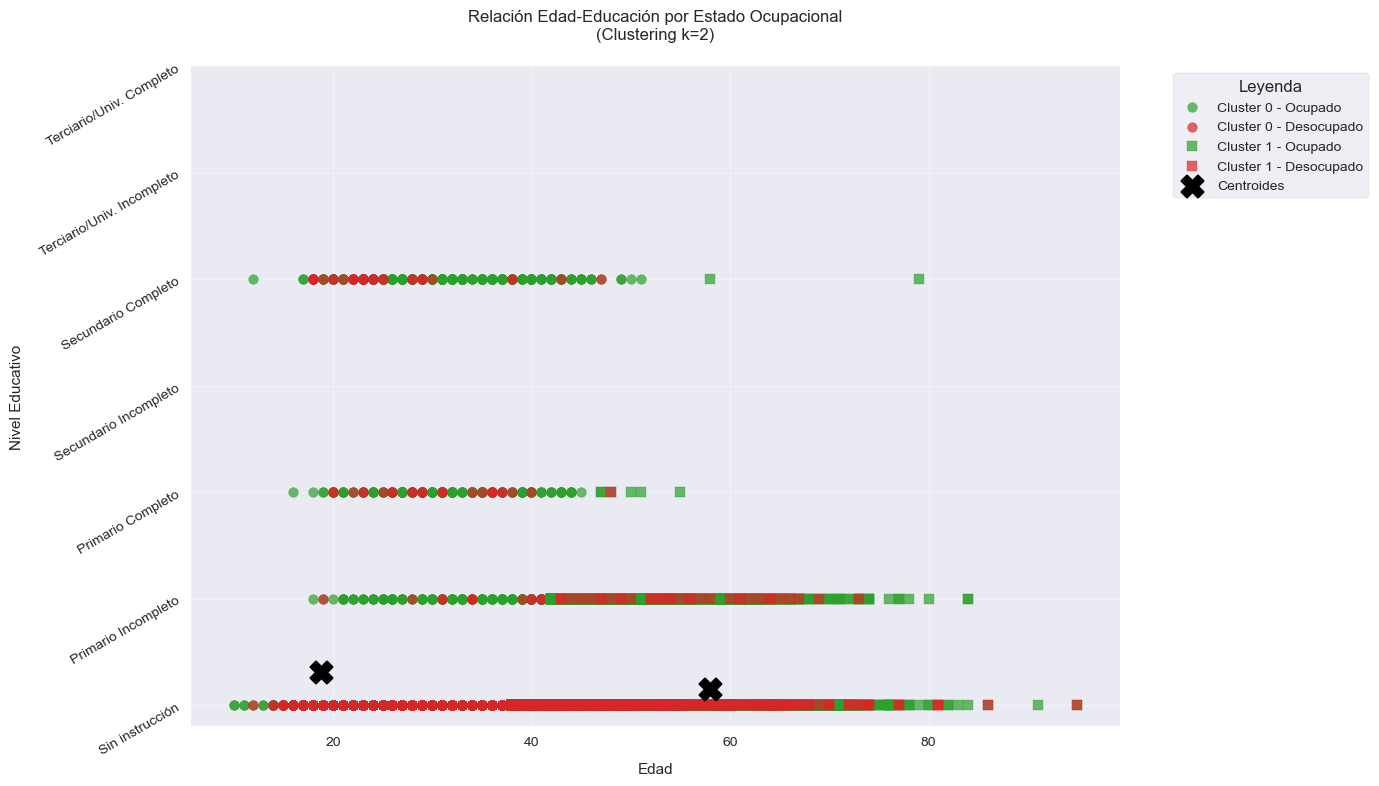


Análisis completado exitosamente


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

# Configuración visual 
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Configuración de archivos y columnas 
FILE_NAME = "archivo_actualizado.xlsx"
SHEETS = {
    'Respondieron_2024_proc': {
        'col_edad': 'edad', 
        'col_nivel_ed': 'nivel_educ', 
        'col_estado': 'ESTADO'  
    },
    'NoRespondieron_2024_proc': {
        'col_edad': 'edad',
        'col_nivel_ed': 'nivel_educ',
        'col_estado': 'ESTADO'  
    },
    '2004_procesado': {
        'col_edad': 'edad',
        'col_nivel_ed': 'CH12',
        'col_estado': 'ESTADO'  
    }
}

# Mapeo educativo 
ORDEN_NIVEL = [
    'Sin instrucción',
    'Primario Incompleto',
    'Primario Completo',
    'Secundario Incompleto',
    'Secundario Completo', 
    'Terciario/Univ. Incompleto',
    'Terciario/Univ. Completo'
]

MAPEO_EDUCATIVO = {
    # Sin instrucción
    'ninguno': 'Sin instrucción', 'na': 'Sin instrucción', '0': 'Sin instrucción',
    
    # Primario
    'primaria incompleta': 'Primario Incompleto', 'primario inc': 'Primario Incompleto',
    'primaria completa': 'Primario Completo', 'primario completo': 'Primario Completo',
    
    # Secundario
    'secundaria inc': 'Secundario Incompleto', 'sec incompleto': 'Secundario Incompleto',
    'secundaria completa': 'Secundario Completo', 'secundario completo': 'Secundario Completo',
    
    # Superior
    'terciario inc': 'Terciario/Univ. Incompleto', 'universidad inc': 'Terciario/Univ. Incompleto',
    'terciario completo': 'Terciario/Univ. Completo', 'universidad completa': 'Terciario/Univ. Completo'
}

def normalizar_estado(estado):
    """Normaliza los estados ocupacionales (actualizado para mayúsculas)"""
    estado = str(estado).strip()  # Mantenemos mayúsculas originales
    
    if estado.lower() == 'ocupado':
        return 'Ocupado'
    elif estado.lower() == 'desocupado':
        return 'Desocupado'
    else:
        return estado  # Mantenemos el valor original si no coincide

def cargar_datos_completos():
    """Carga y normaliza todos los datos"""
    datos_combinados = []
    
    for hoja, config in SHEETS.items():
        try:
            # Cargar datos
            df = pd.read_excel(FILE_NAME, sheet_name=hoja)
            
            # Verificar columnas requeridas
            cols_necesarias = [config['col_edad'], config['col_nivel_ed'], config['col_estado']]
            if not all(col in df.columns for col in cols_necesarias):
                print(f"Advertencia: Faltan columnas en {hoja}")
                continue
                
            # Procesamiento
            df_proc = pd.DataFrame()
            df_proc['edad'] = pd.to_numeric(df[config['col_edad']], errors='coerce')
            
            # Normalizar educación
            educ = df[config['col_nivel_ed']].astype(str).str.lower().str.strip()
            df_proc['nivel_educ'] = educ.map(MAPEO_EDUCATIVO).fillna('Sin instrucción')
            
            # Normalizar estado ocupacional (conservando mayúsculas)
            df_proc['ESTADO'] = df[config['col_estado']].apply(normalizar_estado)
            df_proc['fuente'] = '2024' if '2024' in hoja else '2004'
            
            # Filtrar válidos
            df_proc = df_proc[(df_proc['edad'] > 0) & (df_proc['nivel_educ'].notna())]
            
            if not df_proc.empty:
                datos_combinados.append(df_proc)
                print(f"{hoja}: {len(df_proc)} registros válidos")
                
        except Exception as e:
            print(f"Error en {hoja}: {str(e)}")
    
    if not datos_combinados:
        raise ValueError("No se cargaron datos válidos")
    
    # Combinar y procesar final
    df_final = pd.concat(datos_combinados, ignore_index=True)
    df_final['nivel_educ'] = pd.Categorical(df_final['nivel_educ'], categories=ORDEN_NIVEL, ordered=True)
    df_final['nivel_educ_num'] = df_final['nivel_educ'].cat.codes
    
    return df_final

def analizar_ocupacion(datos):
    """Realiza clustering y análisis por estado ocupacional"""
    try:
        # 1. Preparación de datos
        X = datos[['edad', 'nivel_educ_num']]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # 2. Clustering k=2
        kmeans = KMeans(n_clusters=2, n_init=20, random_state=42)
        datos['cluster'] = kmeans.fit_predict(X_scaled)
        
        # 3. Configuración de gráfico
        fig, ax = plt.subplots()
        
        # Paleta de colores y estilos (actualizado para mayúsculas)
        colores = {'Ocupado': '#2ca02c', 'Desocupado': '#d62728'}
        marcadores = {0: 'o', 1: 's'}  # Círculo y cuadrado para clusters
        
        # 4. Graficar cada combinación
        for cluster in [0, 1]:
            for estado in ['Ocupado', 'Desocupado']:
                subset = datos[(datos['cluster'] == cluster) & (datos['ESTADO'] == estado)]
                if not subset.empty:
                    ax.scatter(
                        subset['edad'], subset['nivel_educ_num'],
                        c=colores[estado],
                        marker=marcadores[cluster],
                        alpha=0.7,
                        label=f'Cluster {cluster} - {estado}'
                    )
        
        # 5. Añadir centroides
        centroides = scaler.inverse_transform(kmeans.cluster_centers_)
        ax.scatter(
            centroides[:, 0], centroides[:, 1],
            s=250, c='black', marker='X', 
            linewidths=1.5, label='Centroides'
        )
        
        # 6. Personalización del gráfico
        ax.set_title('Relación Edad-Educación por Estado Ocupacional\n(Clustering k=2)', pad=20)
        ax.set_xlabel('Edad', labelpad=10)
        ax.set_ylabel('Nivel Educativo', labelpad=10)
        ax.set_yticks(range(len(ORDEN_NIVEL)))
        ax.set_yticklabels(ORDEN_NIVEL, rotation=30)
        
        # Leyenda 
        ax.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            frameon=True,
            title="Leyenda"
        )
        
        plt.tight_layout()
        
        # 7. Análisis cuantitativo
        print("\nANÁLISIS DE SEPARACIÓN OCUPACIONAL")
        print("="*50)
        
        # Matriz de confusión
        conf_mat = confusion_matrix(
            datos['ESTADO'].apply(lambda x: 1 if x == 'Ocupado' else 0),
            datos['cluster']
        )
        
        print("\nMatriz de Confusión (Ocupado vs Cluster):")
        print(conf_mat)
        
        # Pureza de clusters
        total_por_cluster = datos['cluster'].value_counts().sort_index()
        ocupados_por_cluster = datos[datos['ESTADO'] == 'Ocupado']['cluster'].value_counts().sort_index()
        pureza = ocupados_por_cluster / total_por_cluster
        
        print("\nPureza de Clusters (% Ocupados):")
        for cluster, p in pureza.items():
            print(f"Cluster {cluster}: {p:.1%}")
        
        plt.show()
        
    except Exception as e:
        print(f"Error en análisis: {str(e)}")

# Ejecución principal
if __name__ == "__main__":
    print("Iniciando análisis de ocupación...")
    
    try:
        # 1. Cargar datos
        datos = cargar_datos_completos()
        print(f"\nDatos cargados: {len(datos)} registros")
        print("\nDistribución por estado ocupacional:")
        print(datos['ESTADO'].value_counts())
        
        # 2. Análisis de clustering
        analizar_ocupacion(datos)
        
        print("\nAnálisis completado exitosamente")
        
    except Exception as e:
        print(f"\nError en proceso principal: {str(e)}")

In [ ]:
COMENTARIO 5B 

In [ ]:
Se observa en el analisis de separacion Ocupacional que el algoritmo no puede separar las personas ocupadas de las desocupadas de las ocupadas. 

In [ ]:
PUNTO 6 

=== ANÁLISIS DE CLUSTERING JERÁRQUICO ===
Variables utilizadas: edad, edad², salario_semanal, horas_trab

Cargando datos...
Total de registros cargados: 27823

Preprocesando datos...
Registros válidos para clustering: 8876

Realizando clustering jerárquico...


C:\Users\54113\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


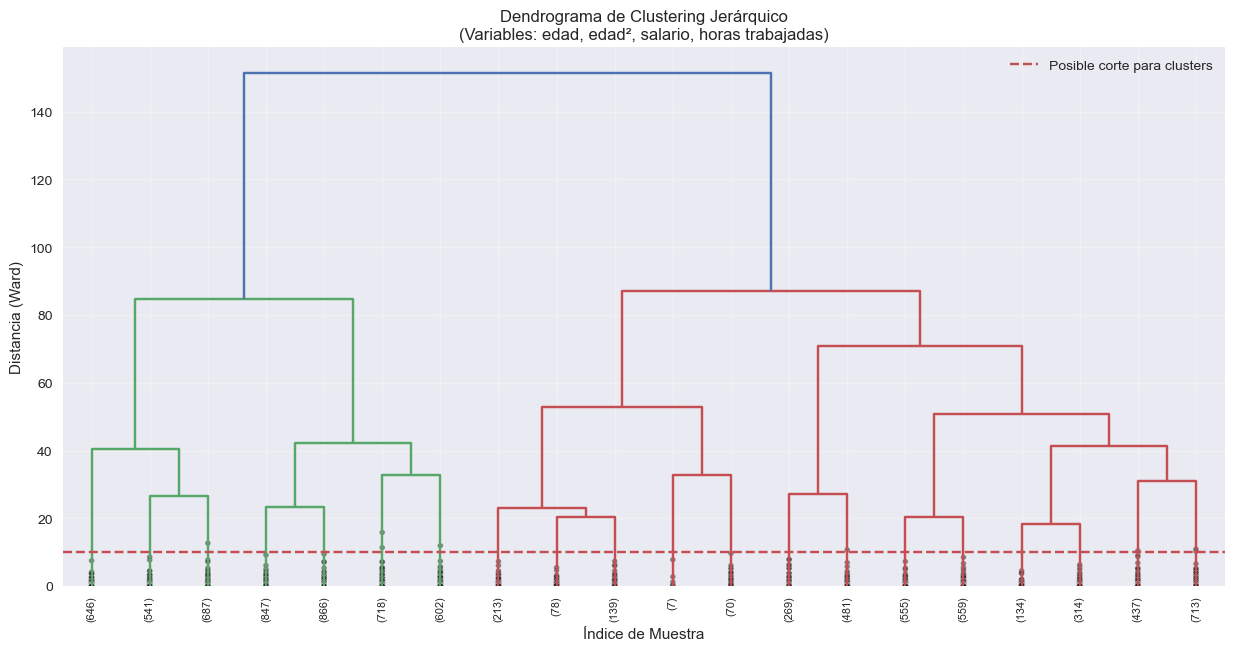


Ingrese el número de clusters basado en el dendrograma:  2



Error en el proceso: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# ====================== CONFIGURACIÓN ======================
FILE_NAME = "archivo_actualizado.xlsx"
SHEETS = {
    'Respondieron_2024_proc': {
        'col_edad': 'edad',
        'col_salario': 'salario_semanal',
        'col_horas': 'horas_trab'
    },
    'NoRespondieron_2024_proc': {
        'col_edad': 'edad',
        'col_salario': 'salario_semanal',
        'col_horas': 'horas_trab'
    },
    '2004_procesado': {
        'col_edad': 'edad',
        'col_salario': 'salario_semanal',
        'col_horas': 'horas_trab'
    }
}

# ====================== FUNCIÓN PARA CARGAR DATOS ======================
def cargar_y_unir_datos():
    dfs = []
    for sheet_name, config in SHEETS.items():
        try:
            df = pd.read_excel(FILE_NAME, sheet_name=sheet_name)
            
            # Verificar columnas requeridas
            required_cols = {
                'edad': config['col_edad'],
                'salario': config['col_salario'],
                'horas': config['col_horas']
            }
            
            missing = [name for name, col in required_cols.items() if col not in df.columns]
            if missing:
                print(f"Advertencia: En hoja {sheet_name} faltan columnas {missing}")
                print(f"Columnas disponibles: {list(df.columns)}")
                continue
            
            # Seleccionar y renombrar columnas
            df = df.rename(columns={
                config['col_edad']: 'edad',
                config['col_salario']: 'salario_semanal',
                config['col_horas']: 'horas_trab'
            })[['edad', 'salario_semanal', 'horas_trab']].copy()
            
            df['fuente'] = sheet_name
            dfs.append(df)
            
        except Exception as e:
            print(f"Error procesando hoja {sheet_name}: {str(e)}")
    
    if not dfs:
        raise ValueError("No se pudieron cargar datos de ninguna hoja")
    
    return pd.concat(dfs, ignore_index=True)

# ====================== PREPROCESAMIENTO ======================
def preprocesar_datos(data):
    # Crear variable edad²
    data['edad2'] = data['edad']**2
    
    # Filtrar valores extremos
    data = data[
        (data['horas_trab'] > 0) & 
        (data['horas_trab'] <= 80) &
        (data['salario_semanal'] > 0)
    ].copy()
    
    # Variables para clustering (edad, edad², salario, horas)
    variables = ['edad', 'edad2', 'salario_semanal', 'horas_trab']
    X = data[variables].dropna()
    
    # Normalización
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, X.index

# ====================== CLUSTERING JERÁRQUICO ======================
def realizar_clustering(X_scaled):
    # Matriz de enlace
    Z = linkage(X_scaled, method='ward', metric='euclidean')
    
    # Dendrograma
    plt.figure(figsize=(15, 7))
    dendrogram(
        Z,
        truncate_mode='lastp',
        p=20,
        show_leaf_counts=True,
        leaf_rotation=90,
        leaf_font_size=8,
        show_contracted=True
    )
    
    plt.title('Dendrograma de Clustering Jerárquico\n(Variables: edad, edad², salario, horas trabajadas)')
    plt.xlabel('Índice de Muestra')
    plt.ylabel('Distancia (Ward)')
    plt.axhline(y=10, color='r', linestyle='--', label='Posible corte para clusters')
    plt.legend()
    plt.show()
    
    return Z

# ====================== ASIGNAR CLUSTERS ======================
def asignar_clusters(Z, data, index_validos, n_clusters):
    # Modelo de clustering
    cluster = AgglomerativeClustering(
        n_clusters=n_clusters,
        affinity='euclidean',
        linkage='ward'
    )
    
    # Ajustar y predecir
    clusters = cluster.fit_predict(Z[:, :2])
    
    # Asignar clusters al dataframe
    data['cluster'] = np.nan
    data.loc[index_validos, 'cluster'] = clusters
    
    return data

# ====================== VISUALIZACIÓN ======================
def visualizar_resultados(data):
    # Configurar estilo
    plt.style.use('seaborn')
    
    # Gráfico 1: Edad vs Salario
    plt.figure(figsize=(12, 6))
    for cluster in sorted(data['cluster'].dropna().unique()):
        cluster_data = data[data['cluster'] == cluster]
        plt.scatter(
            cluster_data['edad'],
            cluster_data['salario_semanal'],
            label=f'Cluster {int(cluster)}',
            alpha=0.6
        )
    
    plt.title('Relación Edad vs Salario por Cluster')
    plt.xlabel('Edad')
    plt.ylabel('Salario Semanal')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Gráfico 2: Horas trabajadas vs Edad²
    plt.figure(figsize=(12, 6))
    for cluster in sorted(data['cluster'].dropna().unique()):
        cluster_data = data[data['cluster'] == cluster]
        plt.scatter(
            cluster_data['horas_trab'],
            cluster_data['edad2'],
            label=f'Cluster {int(cluster)}',
            alpha=0.6
        )
    
    plt.title('Relación Horas Trabajadas vs Edad² por Cluster')
    plt.xlabel('Horas Trabajadas')
    plt.ylabel('Edad²')
    plt.legend()
    plt.grid(True)
    plt.show()

# ====================== ANÁLISIS ESTADÍSTICO ======================
def analizar_clusters(data):
    # Estadísticas por cluster
    stats = data.groupby('cluster').agg({
        'edad': ['mean', 'std', 'count'],
        'edad2': ['mean', 'std'],
        'salario_semanal': ['mean', 'std'],
        'horas_trab': ['mean', 'std']
    })
    
    print("\nESTADÍSTICAS POR CLUSTER:")
    print(stats.round(2))
    
    # Composición por fuente de datos
    if 'fuente' in data.columns:
        print("\nCOMPOSICIÓN POR FUENTE:")
        print(pd.crosstab(data['fuente'], data['cluster']))

def main():
    print("=== ANÁLISIS DE CLUSTERING JERÁRQUICO ===")
    print("Variables utilizadas: edad, edad², salario_semanal, horas_trab\n")
    
    try:
        # 1. Cargar datos
        print("Cargando datos...")
        data = cargar_y_unir_datos()
        print(f"Total de registros cargados: {len(data)}")
        
        # 2. Preprocesamiento
        print("\nPreprocesando datos...")
        X_scaled, index_validos = preprocesar_datos(data)
        print(f"Registros válidos para clustering: {len(X_scaled)}")
        
        # 3. Clustering
        print("\nRealizando clustering jerárquico...")
        Z = realizar_clustering(X_scaled)
        
        # 4. Asignación de clusters
        n_clusters = int(input("\nIngrese el número de clusters basado en el dendrograma: "))
        data = asignar_clusters(Z, data, index_validos, n_clusters)
        
        # 5. Análisis
        print("\nAnalizando resultados...")
        analizar_clusters(data)
        visualizar_resultados(data)
        
        # 6. Guardar resultados
        output_file = "resultados_clustering_edad2.xlsx"
        data.to_excel(output_file, index=False)
        print(f"\nResultados guardados en: {output_file}")
        
    except Exception as e:
        print(f"\nError en el proceso: {str(e)}")

if __name__ == "__main__":
    main()

In [ ]:
COMENTARIO PUNTO 6

Dendrograma: Es un diagrama en forma de árbol utilizado en análisis de clusters (agrupamiento)
para mostrar la organización jerárquica de los datos. Cada rama representa cómo los datos se agrupan en clusters.